<a href="https://colab.research.google.com/github/Gothamv/Stonks/blob/main/StonksProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
#!pip3 install tensorflow-gpu==1.15.2
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import datetime
import pandas_datareader as web
from pandas.plotting import lag_plot
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)
from tensorflow.contrib.rnn import LSTMCell
from tensorflow.nn.rnn_cell import MultiRNNCell
from tensorflow.nn.rnn_cell import DropoutWrapper

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
#GettingStockdata
df = web.DataReader('AAPL', data_source= 'yahoo', start='2009-10-01', end='2019-09-30')
df.reset_index(inplace=True,drop=False)
print(df.head())
df.shape

        Date       High        Low  ...      Close       Volume  Adj Close
0 2009-10-01  26.602858  25.814285  ...  25.837143  131177900.0  22.367144
1 2009-10-02  26.562857  25.907143  ...  26.414286  138327000.0  22.866777
2 2009-10-05  26.694286  26.324286  ...  26.574286  105783300.0  23.005293
3 2009-10-06  27.144285  26.757143  ...  27.144285  151271400.0  23.498735
4 2009-10-07  27.221428  27.004286  ...  27.178572  116417000.0  23.528416

[5 rows x 7 columns]


(2516, 7)

In [ ]:
df.columns
minmax = MinMaxScaler()
df_log = minmax.fit_transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.000000
1,0.002798
2,0.003574
3,0.006338
4,0.006504


In [ ]:
test_size = 30
simulation_size = 1

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
ar_df_train = df.iloc[:-test_size]
ar_df_test = df.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((2516, 7), (2486, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


train loop:   4%|▍         | 12/300 [00:28<11:27,  2.39s/it, acc=97.8, cost=0.00191]

KeyboardInterrupt: ignored

In [ ]:
print(results)

[[200.13969374237027, 200.3779568361011, 198.8526863454461, 197.2406978843266, 198.31984496792077, 197.38083992986907, 197.20563886064514, 198.35214427627608, 201.99975218061905, 201.2328022946858, 201.20308650535196, 203.30590421752115, 202.90324693674748, 197.99964456660524, 197.04341781517252, 197.2527057239117, 197.5778151538699, 199.72037675340144, 200.8403019772902, 203.30185696486404, 203.26213969362533, 201.25893212867635, 198.39517319731803, 199.0406127247434, 200.20308281421612, 203.36282630175407, 204.9131820020284, 206.68896608587386, 201.97767529600594, 197.0087118112216]]


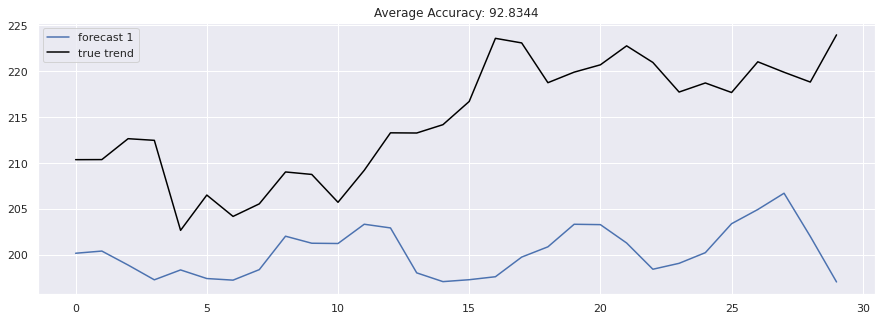

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]
plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
LSTM_accuracy = np.mean(accuracies)
plt.title('Average Accuracy: %.4f' %LSTM_accuracy)
plt.show()

# **ARIMA**

In [ ]:
train_ar = ar_df_train['Close'].values
test_ar = ar_df_test['Close'].values
history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
ARIMA_accuracy = calculate_accuracy(test_ar, predictions)
print('Accuracy of predictions using ARIMA: %.3f' % ARIMA_accuracy)

Accuracy of predictions using ARIMA: 95.898


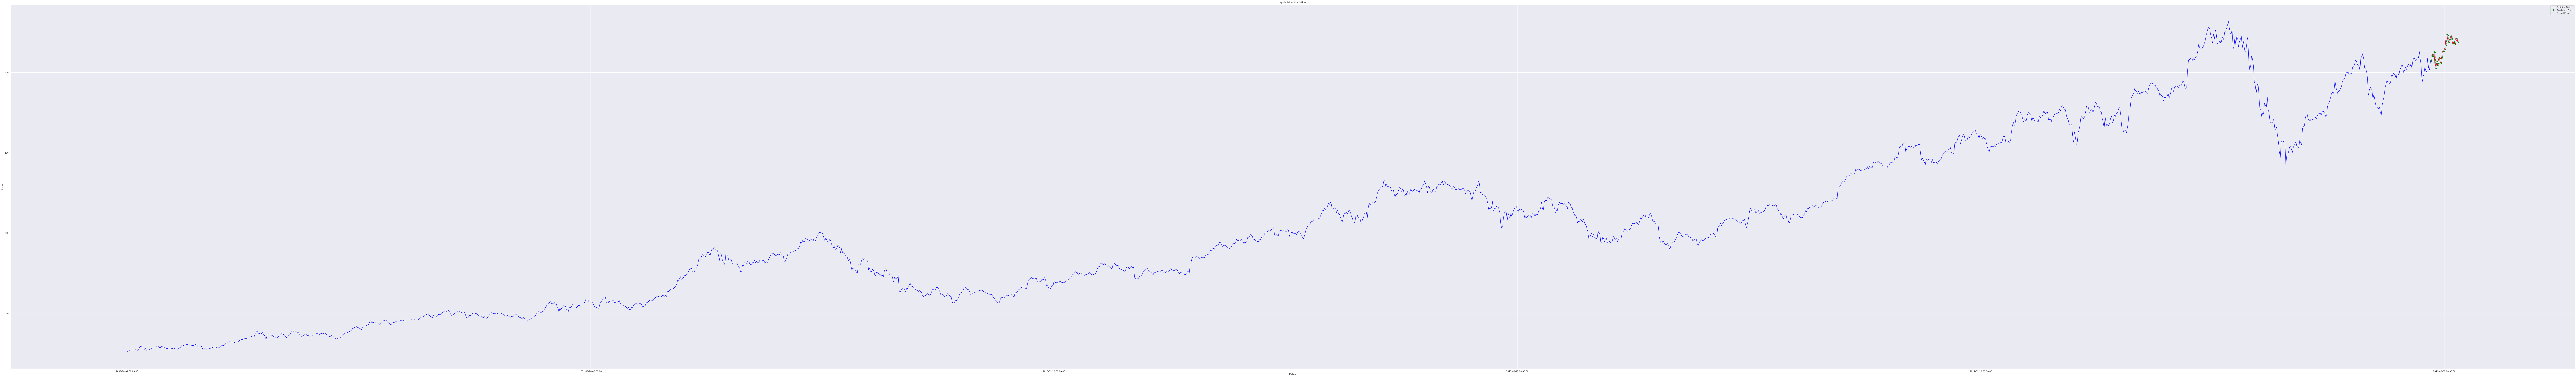

In [ ]:
plt.figure(figsize=(240,35))
plt.plot(df['Close'], color='blue', label='Training Data')
plt.plot(ar_df_test.index, predictions, color='green', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(ar_df_test.index, ar_df_test['Close'], color='red', label='Actual Price')
plt.title('Apple Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,2516, 500), df['Date'][0:2516:500])
plt.legend()